In [1]:
#########################################################################
# Data Exploration - COVID-19 case trend analytics
# Created by George Zhao
# Note: this project needs to checkout the git:
# https://github.com/CSSEGISandData/COVID-19.git
# and has the project structure like this example:
# <Project_parent_home>
#    COVID-19/ (generated from "git clone https://github.com/CSSEGISandData/COVID-19.git" )
#    covid-19-analytics/ (generated from "git clone  https://github.com/chainmaporg/covid-19-analytics.git" )
# 
import pandas as pd
from IPython.display import display, HTML
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)




In [2]:
backdays = 20

In [3]:
## Utilities for the data engineering
##


def barchart(df, x_fld, y_fld, xlabel, ylabel, chartname):
    ax = sns.barplot(x=x_fld, y=y_fld, data=df,  palette=["lightblue"])   
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(chartname)
    #for p in ax.patches:
    #    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

def barchart2(df, x_fld, y_fld, huef, xlabel, ylabel, chartname):
    ax = sns.barplot(x=x_fld, y=y_fld, hue=huef, data=df, palette=["orange", "teal"]) 
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(chartname)
    #for p in ax.patches:
    #    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

def barchart2text(color, df, x_fld, y_fld, huef, xlabel, ylabel, chartname):
    ax = sns.barplot(x=x_fld, y=y_fld, hue=huef, data=df, palette=[color, "teal"]) 
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(chartname)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.show()

def chart(daily_df, fld):
    t=daily_df.iloc[0]["region"]
    if(fld.find("_ratio")>0):
        ax = sns.lineplot(x="day", y=fld, data=daily_df)
    else:
        ax = sns.barplot(x="day", y=fld, data=daily_df, palette=["lightblue"])
    if(fld.find("_growth_pcnt")>0):
        ylabel = "daily growth percentage"
    else:
        ylabel = "daily case count"
    
    ax.set(xlabel='Date ('+t+")", ylabel=ylabel)
    ax.set_title(fld+' number')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()

def linechart(daily_df, fld):
    t=daily_df.iloc[0]["region"]
    ax = sns.lineplot(x="day", y=fld, data=daily_df)
    if(fld.find("_growth_pcnt")>0):
        ylabel = "daily growth percentage"
    else:
        ylabel = "daily case count"
    
    ax.set(xlabel='Date ('+t+")", ylabel=ylabel)
    ax.set_title(fld+' case')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    plt.xticks(rotation='vertical')

    plt.tight_layout()
    plt.show()
    
def getDfFromLocal(filename):
        fullpath=filename
        df = pd.read_csv(fullpath, encoding="utf-8")
        return df
    
def printList(df):
    i=1
    for index, row in df.iterrows():
        print(i, row)
        i=i+1

def genDayList(days, off):
    now = datetime.datetime.now()
    daylist=[]
    for i in range(days):
        yesterday = date.today() - timedelta(days=(days-i+off))
        str = yesterday.strftime("%m-%d-%Y")
        daylist.append(str)
    return daylist


def getCountry(name):
    if(name=="US"):
        return("United States")
    else:
        return name
    
def getCountryPopulation(pop_df, country):
    country = getCountry(country)
    if(country.lower()=="china"):
        return 58.5*1000000
    for index, row in pop_df.iterrows():
        c=row["country"]
        c1=c.lower()
        c2=country.lower()

        if(c1.find(c2)>=0):
            return(row["population"])


In [4]:

## Data Process and data transforming
#
def findCountry():
    df = getDFByDay("03-27-2020")
    return df["Country_Region"].unique()


    
def findState():
    df = getDFByDay("03-27-2020")
    df = df[df["Country_Region"]=="US"]
    list = df["Province_State"].unique()
    return list


dfmap={}
def getDFByDay(day):
    global dfmap
    if(day in dfmap.keys()):
        return dfmap[day]
    
    file=day+".csv"
    filepath = "../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"+file
    df = getDfFromLocal(filepath)
    dfmap[day] = df
    return df


#output a list of cases by the day and tbe state name
def getCasesByState(day, state):
    df = getDFByDay(day)
    new_df = df[df['Province_State'].apply(lambda x: state == x)]
    return new_df

#Cover country/state/couty
def getTotalByRegion(day, region, isCountry):
    df = getDFByDay(day)
    if(region.find("-")>0):
        strs=region.split("-")
        county=strs[0]
        state=strs[1]
        df = df[df['Province_State'].apply(lambda x: state == x)]
        df = df[df['Admin2'].apply(lambda x: county == x)]
    elif isCountry:
        df = df[df['Country_Region'].apply(lambda x: region == x)]
    else:
        df = df[df['Province_State'].apply(lambda x: region == x)]
              
    return df




def getCasesByCounty(day, county, state):
    df = getCasesByState(day, state)
    new_df = df[df['Admin2'].apply(lambda x: county == x)]
    return new_df



def findCounty(state):
    df = getDFByDay("03-27-2020")
    df = df[df["Province_State"]==state]
    print(df.Admin2.unique())


def findTrendSpeedByCounty(day_list, county, state):
    region = county+"-"+state
    return findTrendSpeedByRegion(day_list, region, False)

def findTrendSpeedByState(day_list, state):
    return findTrendSpeedByRegion(day_list, state, False)

def findTrendByCountry(day_list, country):
    return findTrendSpeedByRegion(day_list, country, True)

def findTrendSpeedByCountry(day_list, country):
    return findTrendSpeedByRegion(day_list, country, True)


def findTrendSpeedByRegion(day_list, region, isCountry):
    
    d = {'region': [], 'day': [], 'confirmed': [],'case_growth_pcnt': [],'case_growing': [], 'death':[],'death_growth_pcnt': [], 'death_growing': [],'recovered': [], 'recovered_growing': [],'recovered_ratio': [], 'death_ratio':[]}
    df = pd.DataFrame(d)

    i=0
    c0=0
    d0=0
    r0=0
    for day in day_list:
        day_df = getTotalByRegion(day, region, isCountry)
        if (day_df.shape[0]>0):
            c1 = day_df["Confirmed"].sum()
            d1 = day_df["Deaths"].sum()
            r1 = day_df["Recovered"].sum()
            dc1 = d1*1.0/c1
            
            if(c0>0):
                cc = (c1-c0)*100.0/c0
                cc_num=(c1-c0)
            else:
                cc = 0
                cc_num=0
                
            if(d0>0):
                dd = (d1-d0)*100.0/d0
                dd_num=(d1-d0)
            else:
                dd = 0 
                dd_num=0
 
            if(r0>0):
                rr = (r1)/c1
                rr_num =(r1-r0)
            else:
                rr = 0
                rr_num = 0
                
            new_row = [{"region":region, "day":day[:5], "confirmed":c1, 'case_growth_pcnt':cc,'case_growing':cc_num, "death":d1, 'death_growth_pcnt':dd, 'death_growing':dd_num,'recovered':r1, 'recovered_growing':rr_num,'recovered_ratio':rr, 'death_ratio':dc1}]
            c0=c1
            d0=d1
            r0=r1
        else:
            new_row = [{"region":region, "day":day[:5], "confirmed":0, "case_growth_pcnt":0, "case_growing":0,  "death":0,  "death_growth_pcnt":0, "death_growing":0, "recovered":0, "recovered_growing":0,"recovered_ratio":0, "death_ratio":0}]
            
        df = df.append(new_row, ignore_index=True)
    return df  

    

In [5]:
def getTotalByRegion(day, region, isCountry):
    df = getDFByDay(day)
    if(region.find("-")>0):
        strs=region.split("-")
        county=strs[0]
        state=strs[1]
        df = df[df['Province_State'].apply(lambda x: state == x)]
        df = df[df['Admin2'].apply(lambda x: county == x)]
    elif isCountry:
        df = df[df['Country_Region'].apply(lambda x: region == x)]
    else:
        df = df[df['Province_State'].apply(lambda x: region == x)]
              
    return df



In [6]:
#Get the score of topn countries
def score_top_case_country():
    (topn_confirmed,topn_growth,t_case, t_death, t_recovered) = get_topn_world(20)
    clist = topn_growth['region'].tolist()
    score = 0
    gs = 0
    rs = 0
    glist=[]
    rlist=[]
    for cty in clist:
        day_list = genDayList(backdays, 0)
        df = findTrendSpeedByCountry(day_list, cty)
        (s1, today_rec, numx_number) = getdataConfirmedRecovered(df)
        if s1==0:
            gs+=1
            glist.append(cty)
        if s1==2:
            rs+=1
            rlist.append(cty)
            
        score = score + s1
    return(score, gs, rs, glist,rlist,t_case, t_death, t_recovered)

def score_top_case_us_state():
    (topn_confirmed,topn_growth,t_case, t_death) = get_topn_state(20)
    clist = topn_growth['region'].tolist()
    score = 0
    gs = 0
    rs = 0
    glist=[]
    rlist=[]
    for state in clist:
        day_list = genDayList(backdays, 0)
        df = findTrendSpeedByState(day_list, state)
        (s1, today_rec, numx_growth) = getdataGrowthDeath(df) 
        if s1==0:
            gs+=1
            glist.append(state)
        if s1==2:
            rs+=1
            rlist.append(state)
        score = score + s1
    return(score, gs, rs, glist,rlist, t_case, t_death,)




In [7]:
##Reporting and business layer
#

def htmlRecStateStatus(rec):     
    text = "<hr>"+\
           "<center><table>"+\
           "<tr>"+"<td><b>region</b></td>"+"<td>"+rec["region"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>day</b></td>"+"<td>"+rec["day"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>confirmed</b></td></td>"+"<td>"+rec["confirmed"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>death</b></td>"+"<td>"+rec["death"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>case_growing</b></td>"+"<td>"+rec["case_growing"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>case_growth_pcnt</b></td>"+"<td>"+rec["case_growth_pcnt"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>death_growing</b></td>"+"<td>"+rec["death_growing"]+"</td>"+"</tr>"+\
           ""
    html = HTML(text)    
    return html

def htmlRecCountryStatus(rec): 


    text = "<hr>"+\
           "<table>"+\
           "<tr>"+"<td><b>region</b></td>"+"<td>"+rec["region"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>day</b></td>"+"<td>"+rec["day"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>confirmed</b></td></td>"+"<td>"+rec["confirmed"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>death</b></td>"+"<td>"+rec["death"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>case_growing</b></td>"+"<td>"+rec["case_growing"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>case_growth_pcnt</b></td>"+"<td>"+rec["case_growth_pcnt"]+"</td>"+"</tr>"+\
           "<tr>"+"<td><b>death_growing</b></td>"+"<td>"+rec["death_growing"]+"</td>"+"</tr>"+\
    "<tr>"+"<td><b>recovered</b></td>"+"<td>"+rec["recovered"]+"</td>"+"</tr> </table>"+\
           ""
    html = HTML(text)    
    return html

def getdataGrowthDeath(df):
    today_rec = df[['region', 'day', 'confirmed', 'case_growing','case_growth_pcnt', 'death', 'death_growing','death_growth_pcnt']].iloc[-1]
    pre_rec = df[['region', 'day', 'confirmed', 'case_growing', 'case_growth_pcnt','death', 'death_growing','death_growth_pcnt']].iloc[-2]
     
    c_i = today_rec["case_growing"] - pre_rec["case_growing"]
    d_i = today_rec["death_growing"] - pre_rec["death_growing"]
    
    
    today_rec["confirmed"]= '%.0f' % (today_rec["confirmed"]) + " (was:"+ '%.0f' % pre_rec["confirmed"]+")"
    today_rec["death"] = '%.0f' % today_rec["death"] + " (was:"+ '%.0f' %pre_rec["death"]+")"
    today_rec["case_growing"] = '%.0f' % today_rec["case_growing"] + " (was:"+ '%.0f' %pre_rec["case_growing"]+")"
    today_rec["death_growing"] = '%.0f' % today_rec["death_growing"] + " (was:"+ '%.0f' %pre_rec["death_growing"]+")"
    today_rec["case_growth_pcnt"] = '%.2f' % today_rec["case_growth_pcnt"] + "% (was:"+ '%.2f' %pre_rec["case_growth_pcnt"]+"%)"
    today_rec["death_growth_pcnt"] = '%.2f' % today_rec["death_growth_pcnt"] + "% (was:"+ '%.2f' %pre_rec["death_growth_pcnt"]+"%)"
    numx_growth = pd.melt(df, id_vars='day',
                         value_vars=["case_growing", "death_growing"],
                         var_name="type", value_name="nums")
    score=0
    if(c_i<=0 and d_i<=0):
        score=0
    elif(c_i<=0 and d_i>0):
        score=1
    else:
        score=2
    return (score, today_rec, numx_growth)


def chartGrowthDeath(df, title):
    (score, today_rec, numx_growth) = getdataGrowthDeath(df)  
    #display(htmlRecStateStatus(today_rec))

    if(score==0):
        text="GREEN"
        display (Markdown('<center><span style="color: green">'+text+'</span></center>'))
    elif(score==1):
        text="ORANGE"
        display (Markdown('<center><span style="color: orange">'+text+'</span></center>'))
    else:
        text="RED"
        display (Markdown('<center><span style="color: red">'+text+'</span></center>'))

    barchart2text("orange", numx_growth, "day","nums", "type", "Date", "Counts", title+":Confirmed Case/Death Growing")
    return


def getdataConfirmedRecovered(df):
    today_rec = df[['region', 'day', 'confirmed', 'case_growing','case_growth_pcnt', 'death', 'death_growing', 'recovered','recovered_ratio']].iloc[-1]
    pre_rec = df[['region', 'day', 'confirmed', 'case_growing', 'case_growth_pcnt','death', 'death_growing', 'recovered','recovered_ratio']].iloc[-2]
     
    c_i = today_rec["case_growing"] - pre_rec["case_growing"]
    d_i = today_rec["death_growing"] - pre_rec["death_growing"]
    
    
    today_rec["confirmed"]= '%.0f' % (today_rec["confirmed"]) + " (was:"+ '%.0f' % pre_rec["confirmed"]+")"
    today_rec["death"] = '%.0f' % today_rec["death"] + " (was:"+ '%.0f' %pre_rec["death"]+")"
    today_rec["case_growing"] = '%.0f' % today_rec["case_growing"] + " (was:"+ '%.0f' %pre_rec["case_growing"]+")"
    today_rec["case_growth_pcnt"] = '%.2f' % today_rec["case_growth_pcnt"] + "% (was:"+ '%.2f' %pre_rec["case_growth_pcnt"]+"%)"
    today_rec["death_growing"] = '%.0f' % today_rec["death_growing"] + " (was:"+ '%.0f' %pre_rec["death_growing"]+")"
    today_rec["recovered"]= '%.0f' % (today_rec["recovered"]) + " (was:"+ '%.0f' % pre_rec["recovered"]+")"


    score=0
    if(c_i<=0 and d_i<=0):
        score=0
    elif(c_i<=0 and d_i>0):
        score=1
    else:
        score=2

    numx_number = pd.melt(df, id_vars='day',
                         value_vars=["case_growing", "recovered_growing"],
                         var_name="type", value_name="nums")
 
    return (score, today_rec, numx_number)

   
def chartConfirmedRecovered(df, title):
    (score, today_rec, numx_number) = getdataConfirmedRecovered(df)
    display(htmlRecCountryStatus(today_rec))

    if(score==0):
        text="GREEN"
        display (Markdown('<center><span style="color: green">'+text+'</span></center>'))
    elif(score==1):
        text="ORANGE"
        display (Markdown('<center><span style="color: orange">'+text+'</span></center>'))
    else:
        text="RED"
        display (Markdown('<center><span style="color: red">'+text+'</span></center>'))

    barchart2(numx_number, "day","nums", "type", "Date", "Counts", title+":Confirmed Daily Case/Recovered Daily Case")
    return



def chartRegionAll(df1):
    chart(df1, "confirmed")
    chart(df1, "death")
    chart(df1, "case_growing")
    chart(df1, "recovered")
    chart(df1, "recovered_ratio")
    chart(df1, "death_ratio")

def chartRegion(df1):
    chart(df1, "confirmed")
    chart(df1, "death")
    chart(df1, "case_growing")
    chart(df1, "death_ratio")


def chartRegion_C_R(title, df1):
    return chartConfirmedRecovered(df1, title)

def chartRegion_C_D_Growth(title, df1):
    return chartGrowthDeath(df1, title)

    

def report_local():
    day_list = genDayList(backdays, 0)
    
    df1= findTrendSpeedByCounty(day_list, "Suffolk", "Massachusetts")
    chartRegion(df1)
    
    df1= findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chartRegion(df1)
    
    df1= findTrendSpeedByCounty(day_list, "Fairfax", "Virginia")
    chartRegion(df1)
    
    latest = day_list[len(day_list)-1]
    df1= getCasesByState(day_list[6], "Oregon")
    df1 =df1[["Admin2", "Province_State", "Confirmed", "Deaths"]]
    df1 = df1.sort_values(by=['Confirmed'], ascending=False) 
    df1= findTrendSpeedByState(day_list,"Oregon")
    chartRegion(df1)
    
def report_friend():
    day_list = genDayList(backdays, 0)
    df1= findTrendSpeedByCounty(day_list, "Fairfax", "Virginia")
    chartRegion(df1)
    latest = day_list[len(day_list)-1]
    df1= getCasesByState(day_list[6], "Virginia")
    df1 =df1[["Admin2", "Province_State", "Confirmed", "Deaths"]]
    df1 = df1.sort_values(by=['Confirmed'], ascending=False) 
    df1= findTrendSpeedByState(day_list,"Virginia")
    chartRegion(df1)


def report_SC():
    day_list = genDayList(backdays, 0)
    df1= findTrendSpeedByCounty(day_list, "Santa Clara", "California")
    chartRegion(df1)
    latest = day_list[len(day_list)-1]
    df1= getCasesByState(day_list[6], "California")
    df1 =df1[["Admin2", "Province_State", "Confirmed", "Deaths"]]
    df1 = df1.sort_values(by=['Confirmed'], ascending=False) 
    df1= findTrendSpeedByState(day_list,"California")
    chartRegion(df1)


def report_NY():
    day_list = genDayList(backdays, 0)
    df = findTrendSpeedByState(day_list, "New York")
    chartRegion(df)
    
def getdata_US():
    day_list = genDayList(backdays, 0)
    df = findTrendSpeedByCountry(day_list, "US")
    (score, today_rec, numx_number) = getdataConfirmedRecovered(df)
    return(today_rec)

def report_US():
    day_list = genDayList(backdays, 0)
    df = findTrendSpeedByCountry(day_list, "US")
    chartRegionAll(df)

def report_top_growth():
    (topn_confirmed,topn_growth, t_case, t_death, t_recovered) = get_topn_world(20)
    clist = topn_growth['region'].tolist()
    i=0
    for cty in clist:
        i=i+1
        display(HTML("<h3>"+str(i)+":"+cty+"</h3>"))
        day_list = genDayList(backdays, 0)
        df = findTrendSpeedByCountry(day_list, cty)
        chartRegion_C_R(cty, df)

def report_top_state():
    (topn_confirmed,topn_growth, t_case, t_death) = get_topn_state(20)
    clist = topn_growth['region'].tolist()
    i=0
    for state in clist:
        i=i+1
        display(HTML("<h3>"+str(i)+":"+state+"</h3>"))
        day_list = genDayList(backdays, 0)
        df = findTrendSpeedByState(day_list, state)
        chartRegion_C_D_Growth(state, df)
 
    
def report_world():
    day_list = genDayList(backdays, 0)
    clist = findCountry()
    for cty in clist: 
        if(cty=="China" or cty=="Korea, South" or cty=="Taiwan*"):
            df = findTrendSpeedByCountry(day_list, cty)
            #chartRegionAll(df)
            chartGrowthDeath(df)


def mydisplay(title, df):
    pd.set_option('display.width', -1)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', -1)
    display(HTML("<center><span style='color:red'><h2>"+title+"</h2> </span>  </center>"))
    display(HTML("<center>"+df.to_html(index=False)+"</center>"))

def get_topn_world(n):
    day_list = genDayList(backdays, 0)
    clist = findCountry()
    d = {'region': [], 'confirmed': [],'case_growing': [],'case_growth_pcnt': [], 'death':[], 'recovered': [],'recovered_ratio': []}
    world_df= pd.DataFrame(d)
    (t_case, t_death, t_recovered)=(0,0,0)
    for cty in clist:
        if(True):
            df = findTrendSpeedByCountry(day_list, cty)
            confirmed = df.iloc[len(day_list)-1]["confirmed"]
            case_growth_pcnt = df.iloc[len(day_list)-1]["case_growth_pcnt"]
            case_growing = df.iloc[len(day_list)-1]["case_growing"]            
            death = df.iloc[len(day_list)-1]["death"] 
            recovered=df.iloc[len(day_list)-1]["recovered"]
            recovered_ratio = recovered*1.0/confirmed
            new_row = [{"region":cty, "confirmed":confirmed, 'case_growing':case_growing,'case_growth_pcnt':case_growth_pcnt,   'death':death, 'recovered':recovered, 'recovered_ratio': recovered_ratio}]       
            world_df = world_df.append(new_row)
            (t_case, t_death, t_recovered)=(t_case+confirmed,t_death+death,t_recovered+recovered)
            
    topn_confirmed = world_df.sort_values(by=['confirmed'], ascending=False)[:n]
    topn_growth = topn_confirmed.sort_values(by=['case_growing'], ascending=False)[:n]
    return (topn_confirmed, topn_growth,t_case, t_death, t_recovered)


def get_topn_state(n):
    day_list = genDayList(backdays, 0)
    slist = findState()
    d = {'region': [], 'confirmed': [],'case_growing': [],'case_growth_pcnt': [], 'death':[]}
    state_df= pd.DataFrame(d)
    (t_case, t_death, t_recovered)=(0,0,0)
    for state in slist:
        if(True):
            df = findTrendSpeedByState(day_list, state)
            confirmed = df.iloc[len(day_list)-1]["confirmed"]
            case_growing = df.iloc[len(day_list)-1]["case_growing"]
            case_growth_pcnt = df.iloc[len(day_list)-1]["case_growth_pcnt"]
            death = df.iloc[len(day_list)-1]["death"] 
            new_row = [{"region":state, "confirmed":confirmed, 'case_growing':case_growing,'case_growth_pcnt':case_growth_pcnt,   'death':death}]       
            state_df = state_df.append(new_row)
            (t_case, t_death)=(t_case+confirmed,t_death+death)


            
    topn_confirmed = state_df.sort_values(by=['confirmed'], ascending=False)[:n]
    topn_growth = topn_confirmed.sort_values(by=['case_growing'], ascending=False)[:n]
    return (topn_confirmed, topn_growth,t_case, t_death)



    
def top_world():
    (topn_confirmed, topn_growth, t_case, t_death, t_recovered) = get_topn_world(20)
    mydisplay("Top confirmed case countries sorted by case growth", topn_growth)
    
def top_US():
    (topn_confirmed, topn_growth,t_case, t_death) = get_topn_state(20)
    mydisplay("Top confirmed case states in US sorted by case growth", topn_growth)


    
def all_run(idx):
    if(idx==0):
        report_top_growth()
        
    if(idx==1):
        top_world()
        top_US()
    
    if(idx==7):
        report_US()
        #print("-------US DONE-----")
        
    if(idx==2):
        report_local()
        #print("-------LOCAL DONE-----")
    if(idx==3):
        report_NY()
        #print("-------NY DONE-----")
    if(idx==4):
        report_SC()
        #print("-------SC DONE-----")
    if(idx==5):
        report_world()
        #print("-------World DONE-----")
    if(idx==6):
        top_world()
        
    if(idx==8):
        (cdf, gdf) = get_topn_world(20)
        display(cdf.head(20))
    if(idx==9):
        report_friend()
    if(idx==10):
        report_top_state()
        



In [8]:
import datetime 
  # using now() to get current time 
now = datetime.datetime.now() 

date_time = now.strftime("%m-%d-%Y")
(score1, gs1, rs1, c_glist, c_rlist, t_case, t_death, t_recovered) = score_top_case_country()
(score2, gs2, rs2, s_glist, s_rlist, t_case2, t_death2) = score_top_case_us_state()
today_rec = getdata_US()
c_rec =str('%.1f' % (t_recovered*100.0/t_case))+"%"
#dddd
ratio = float(today_rec["recovered_ratio"])
ratio=ratio*100
us_rec = str('%.1f' % ratio)+"%"
g1 = today_rec["case_growth_pcnt"]

html = "<center><h1>Hope Rising Report (COVID-19 RRR_DATE Update)</h1>"+\
    ""+\
"<br>"+\
"</center>"+\
"<br>"+\
"<center> <img width='200' src='./hope.jpg'/></center>"+\
"<center> <br>"+\
"    (<b>Status</b>: <font color='green'>green</font> means case/death growth down from the day before)<br>"+\
"    (<b>Status</b>: <font color='red'>red</font> means case/death growth up from the day before)"+\
"<br>"+\
"    <h2> Global Recovering Ratio  <font size='32'>RRR_C_REC</font> </h2><table border='1'> "+\
"    <h2> US Recovering Ratio  <font size='32'>RRR_US_REC</font> </h2><table border='1'> "+\
"    <h2> US Daily growth Ratio  <font size='32'>RRR_US_GROW</font> </h2><table border='1'> "+\
"    <tr><th> Item </th> <th> Today </th> </tr>"+\
"    <tr><td> Top-20 Country Green Countries</td> <th> <font color='green'>RRR_C_GLIST </font></th> </tr>"+\
"    <tr><td> Top-20 Country Red Countries</td> <th> <font color='red'>RRR_C_RLIST </font></th> </tr>"+\
"    <tr><td> Top-20 Country total case</td> <th>  RRR_C_TCASE </th> </tr>"+\
"    <tr><td> Top-20 Country total death</td> <th> RRR_C_TDEATH </th> </tr>"+\
"    <tr><td> Top-20 Country total recovered</td> <th> RRR_C_TRECOVERED </th> </tr>"+\
"    <tr><td> Top-20 US Green States</td> <th> <font color='green'>RRR_S_GLIST </font></th> </tr>"+\
"    <tr><td> Top-20 US Red States</td> <th> <font color='red'>RRR_S_RLIST </font></th> </tr>"+\
"    </table></center>"+\
"<br>"

html = html.replace("RRR_DATE", date_time)
#html = html.replace("RRR_C_SCORE", str(score1))
#html = html.replace("RRR_C_GREEN", str(gs1))
#html = html.replace("RRR_S_SCRORE", str(score2))
#html = html.replace("RRR_S_GREEN", str(gs2))
html = html.replace("RRR_C_REC", c_rec)
html = html.replace("RRR_US_REC", us_rec)
html = html.replace("RRR_US_GROW", g1)
html = html.replace("RRR_C_GLIST", str(c_glist))
html = html.replace("RRR_S_GLIST", str(s_glist))
html = html.replace("RRR_C_RLIST", str(c_rlist))
html = html.replace("RRR_S_RLIST", str(s_rlist))
html = html.replace("RRR_C_TCASE", str(int(t_case)))
html = html.replace("RRR_C_TDEATH", str(int(t_death)))
html = html.replace("RRR_C_TRECOVERED", str(int(t_recovered)))
display(HTML(html))
display(htmlRecStateStatus(today_rec))



Item,Today
Top-20 Country Green Countries,"['US', 'Canada', 'Italy', 'Spain', 'France']"
Top-20 Country Red Countries,"['Brazil', 'Russia', 'United Kingdom', 'Pakistan', 'Mexico', 'Saudi Arabia', 'Iran', 'Turkey', 'Germany', 'Belgium', 'China']"
Top-20 Country total case,4539139
Top-20 Country total death,307569
Top-20 Country total recovered,1636854
Top-20 US Green States,"['Illinois', 'California', 'Texas', 'Massachusetts', 'Maryland', 'Virginia', 'Ohio', 'Michigan', 'Louisiana', 'Tennessee', 'Washington']"
Top-20 US Red States,"['New York', 'New Jersey', 'Pennsylvania', 'Florida', 'Georgia', 'Connecticut', 'Indiana', 'Colorado']"


region,US
day,05-15
confirmed,1442824 (was:1417774)
death,87530 (was:85898)
case_growing,25050 (was:27368)
case_growth_pcnt,1.77% (was:1.97%)
death_growing,1632 (was:1779)


In [9]:
#"""
#<h2>This reports covered the below cases</h2>
#<ul>
#    <li><b>Confirmed cases</b> - The total number is the key metrics, and its daily growth is monitored
#    <li><b>Number of Death cases</b> - Death can reflect to the status of Virus infection and medical capability
#    <li><b>Recoverd case</b> - Good news come from this number
#    <li><b>Recoverd ratio</b> - recovered/confirmed (0..1)
#    <li><b>Case growing </b> - The daily growing of the confirmed cases
#    <li><b>Case growth (%) </b> - The daily growth of the confirmed number (0..100)
#    <li><b>Death growth (%) </b> - The daily growth of the death growth (0..100)
#    <li><b>Death ratio</b> - The death ratio against the confirmed number (0..1)
#</ul>
##
#"""

<h2> Overview of global top-20 country situation on COVID-19</h2>


In [10]:
display(HTML("""
<style>
.output {
    align-items: left;
    text-align: left;
}
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>
"""))


all_run(1)

region,confirmed,case_growing,case_growth_pcnt,death,recovered,recovered_ratio
US,1442824.0,25050.0,1.766854,87530.0,250747.0,0.173789
Brazil,220291.0,17126.0,8.429602,14962.0,84970.0,0.385717
Russia,262843.0,10598.0,4.201471,2418.0,58226.0,0.221524
Peru,84495.0,3891.0,4.827304,2392.0,27147.0,0.321285
India,85784.0,3787.0,4.618462,2753.0,30258.0,0.352723
United Kingdom,238004.0,3564.0,1.520218,34078.0,1047.0,0.004399
Pakistan,38799.0,3011.0,8.413435,834.0,10880.0,0.280420
Chile,39542.0,2502.0,6.754860,394.0,16614.0,0.420161
Mexico,45032.0,2437.0,5.721329,4767.0,30451.0,0.676208
Saudi Arabia,49176.0,2307.0,4.922230,292.0,21869.0,0.444709


region,confirmed,case_growing,case_growth_pcnt,death
New York,345813.0,2762.0,0.805128,27878.0
Illinois,90369.0,2432.0,2.765616,4059.0
California,76693.0,1822.0,2.433519,3136.0
New Jersey,143984.0,1280.0,0.896962,10148.0
Texas,45721.0,1241.0,2.790018,1280.0
Massachusetts,83421.0,1239.0,1.507629,5592.0
Maryland,36986.0,1083.0,3.016461,1911.0
Pennsylvania,64136.0,1031.0,1.633785,4422.0
Florida,44138.0,928.0,2.147651,1917.0
Virginia,28672.0,859.0,3.088484,978.0


<h2>Analytics on top-20 countries with most confirmed case </h2>

region,US
day,05-15
confirmed,1442824 (was:1417774)
death,87530 (was:85898)
case_growing,25050 (was:27368)
case_growth_pcnt,1.77% (was:1.97%)
death_growing,1632 (was:1779)
recovered,250747 (was:246414)


<center><span style="color: green">GREEN</span></center>

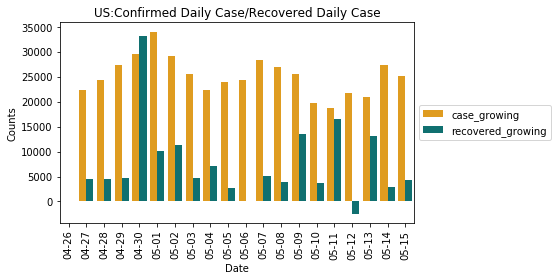

region,Brazil
day,05-15
confirmed,220291 (was:203165)
death,14962 (was:13999)
case_growing,17126 (was:13028)
case_growth_pcnt,8.43% (was:6.85%)
death_growing,963 (was:759)
recovered,84970 (was:79479)


<center><span style="color: red">RED</span></center>

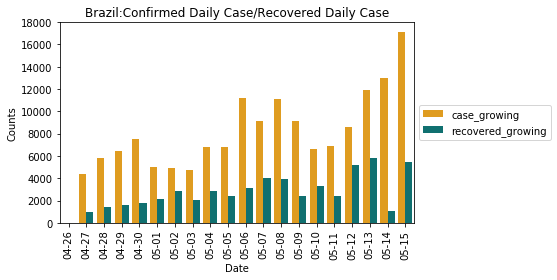

region,Russia
day,05-15
confirmed,262843 (was:252245)
death,2418 (was:2305)
case_growing,10598 (was:9974)
case_growth_pcnt,4.20% (was:4.12%)
death_growing,113 (was:93)
recovered,58226 (was:53530)


<center><span style="color: red">RED</span></center>

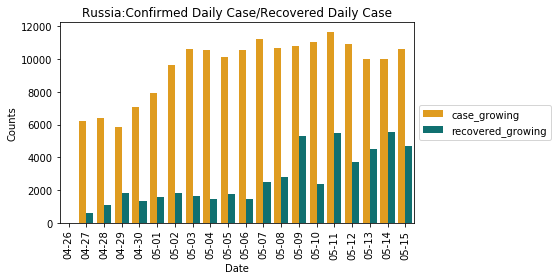

region,Peru
day,05-15
confirmed,84495 (was:80604)
death,2392 (was:2267)
case_growing,3891 (was:4298)
case_growth_pcnt,4.83% (was:5.63%)
death_growing,125 (was:98)
recovered,27147 (was:25151)


<center><span style="color: orange">ORANGE</span></center>

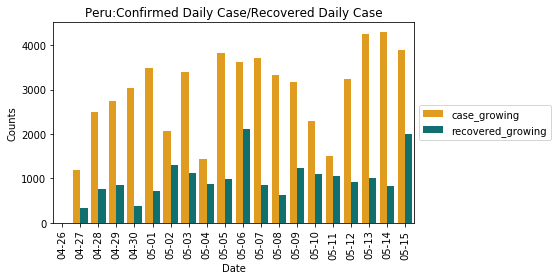

region,India
day,05-15
confirmed,85784 (was:81997)
death,2753 (was:2649)
case_growing,3787 (was:3942)
case_growth_pcnt,4.62% (was:5.05%)
death_growing,104 (was:98)
recovered,30258 (was:27969)


<center><span style="color: orange">ORANGE</span></center>

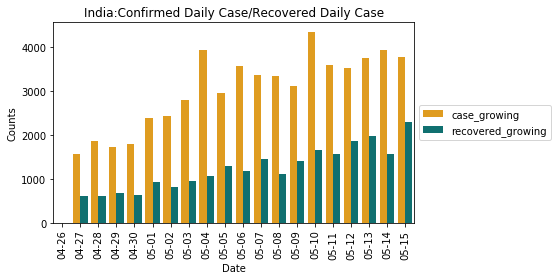

region,United Kingdom
day,05-15
confirmed,238004 (was:234440)
death,34078 (was:33693)
case_growing,3564 (was:3455)
case_growth_pcnt,1.52% (was:1.50%)
death_growing,385 (was:429)
recovered,1047 (was:1043)


<center><span style="color: red">RED</span></center>

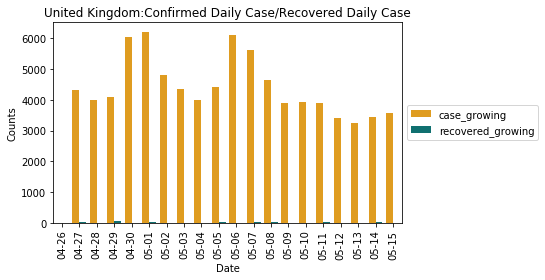

region,Pakistan
day,05-15
confirmed,38799 (was:35788)
death,834 (was:770)
case_growing,3011 (was:490)
case_growth_pcnt,8.41% (was:1.39%)
death_growing,64 (was:9)
recovered,10880 (was:9695)


<center><span style="color: red">RED</span></center>

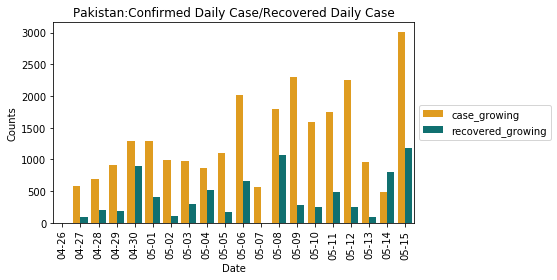

region,Chile
day,05-15
confirmed,39542 (was:37040)
death,394 (was:368)
case_growing,2502 (was:2659)
case_growth_pcnt,6.75% (was:7.73%)
death_growing,26 (was:22)
recovered,16614 (was:15655)


<center><span style="color: orange">ORANGE</span></center>

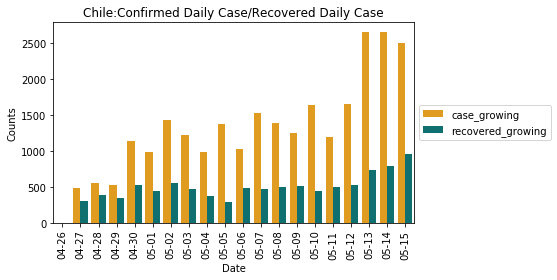

region,Mexico
day,05-15
confirmed,45032 (was:42595)
death,4767 (was:4477)
case_growing,2437 (was:2409)
case_growth_pcnt,5.72% (was:5.99%)
death_growing,290 (was:257)
recovered,30451 (was:28475)


<center><span style="color: red">RED</span></center>

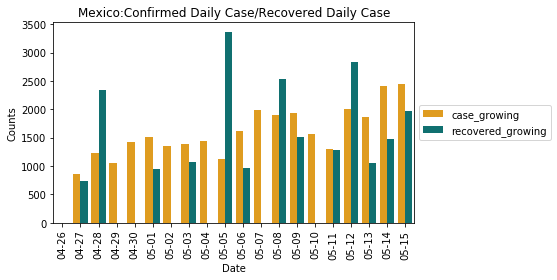

region,Saudi Arabia
day,05-15
confirmed,49176 (was:46869)
death,292 (was:283)
case_growing,2307 (was:2039)
case_growth_pcnt,4.92% (was:4.55%)
death_growing,9 (was:10)
recovered,21869 (was:19051)


<center><span style="color: red">RED</span></center>

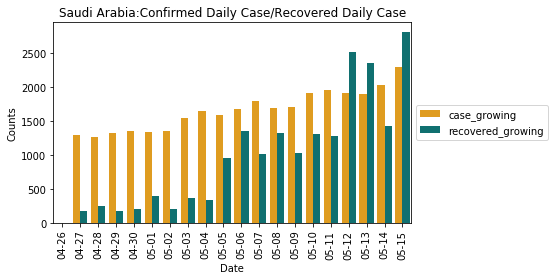

region,Iran
day,05-15
confirmed,116635 (was:114533)
death,6902 (was:6854)
case_growing,2102 (was:1808)
case_growth_pcnt,1.84% (was:1.60%)
death_growing,48 (was:71)
recovered,91836 (was:90539)


<center><span style="color: red">RED</span></center>

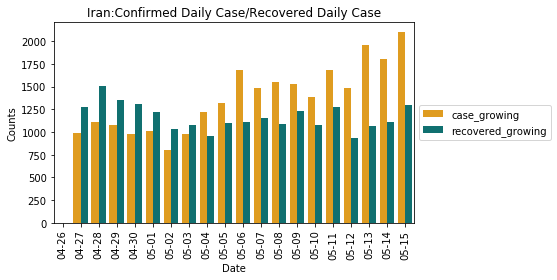

region,Turkey
day,05-15
confirmed,146457 (was:144749)
death,4055 (was:4007)
case_growing,1708 (was:1635)
case_growth_pcnt,1.18% (was:1.14%)
death_growing,48 (was:55)
recovered,106133 (was:104030)


<center><span style="color: red">RED</span></center>

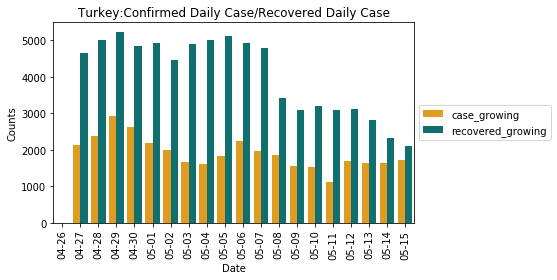

region,Canada
day,05-15
confirmed,75959 (was:74781)
death,5679 (was:5592)
case_growing,1178 (was:1213)
case_growth_pcnt,1.58% (was:1.65%)
death_growing,87 (was:167)
recovered,36908 (was:36104)


<center><span style="color: green">GREEN</span></center>

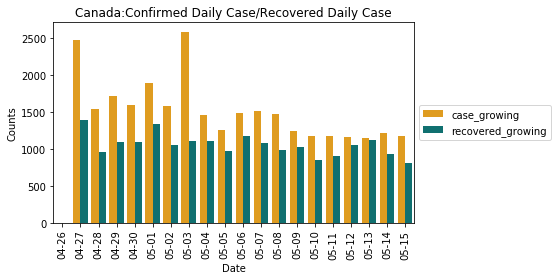

region,Italy
day,05-15
confirmed,223885 (was:223096)
death,31610 (was:31368)
case_growing,789 (was:992)
case_growth_pcnt,0.35% (was:0.45%)
death_growing,242 (was:262)
recovered,120205 (was:115288)


<center><span style="color: green">GREEN</span></center>

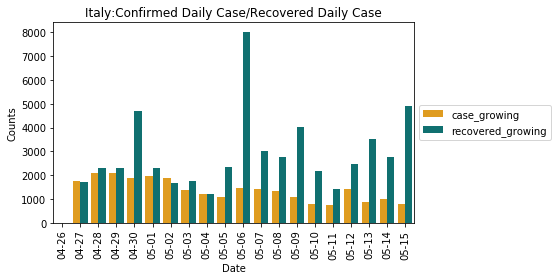

region,Germany
day,05-15
confirmed,175233 (was:174478)
death,7897 (was:7884)
case_growing,755 (was:380)
case_growth_pcnt,0.43% (was:0.22%)
death_growing,13 (was:23)
recovered,151597 (was:150300)


<center><span style="color: red">RED</span></center>

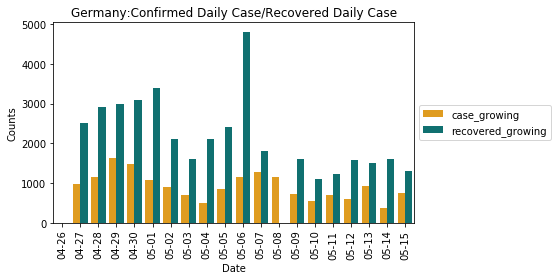

region,Spain
day,05-15
confirmed,230183 (was:229540)
death,27459 (was:27321)
case_growing,643 (was:849)
case_growth_pcnt,0.28% (was:0.37%)
death_growing,138 (was:217)
recovered,144783 (was:143374)


<center><span style="color: green">GREEN</span></center>

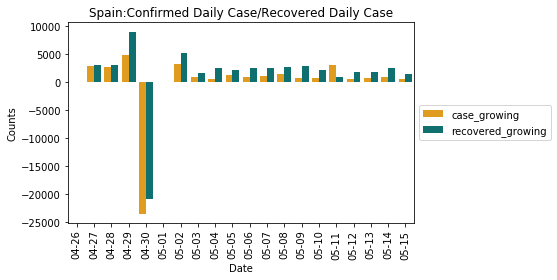

region,France
day,05-15
confirmed,179630 (was:178994)
death,27532 (was:27428)
case_growing,636 (was:810)
case_growth_pcnt,0.36% (was:0.45%)
death_growing,104 (was:351)
recovered,60562 (was:59719)


<center><span style="color: green">GREEN</span></center>

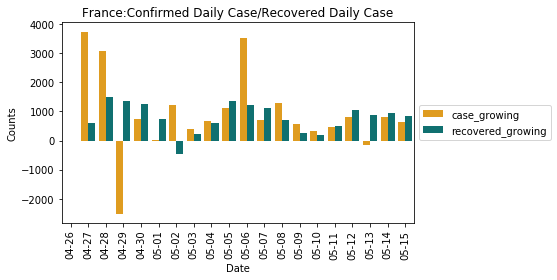

region,Belgium
day,05-15
confirmed,54644 (was:54288)
death,8959 (was:8903)
case_growing,356 (was:307)
case_growth_pcnt,0.66% (was:0.57%)
death_growing,56 (was:60)
recovered,14301 (was:14111)


<center><span style="color: red">RED</span></center>

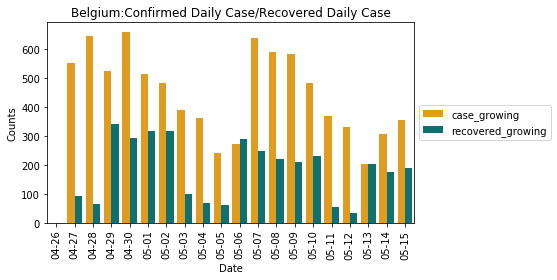

region,Netherlands
day,05-15
confirmed,43880 (was:43680)
death,5662 (was:5609)
case_growing,200 (was:270)
case_growth_pcnt,0.46% (was:0.62%)
death_growing,53 (was:28)
recovered,159 (was:159)


<center><span style="color: orange">ORANGE</span></center>

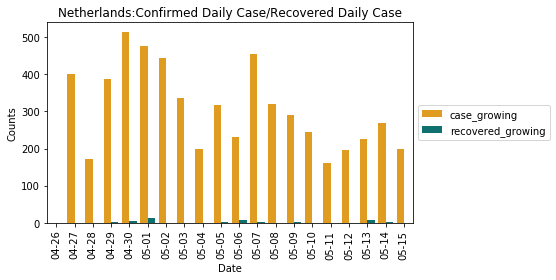

region,China
day,05-15
confirmed,84038 (was:84029)
death,4637 (was:4637)
case_growing,9 (was:5)
case_growth_pcnt,0.01% (was:0.01%)
death_growing,0 (was:0)
recovered,79281 (was:79261)


<center><span style="color: red">RED</span></center>

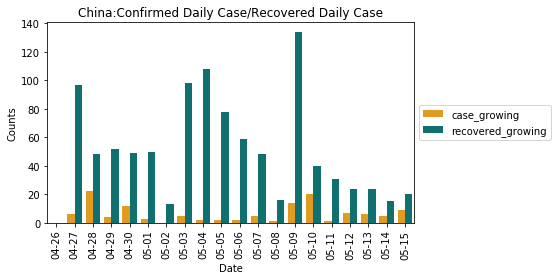

In [11]:
all_run(0)

<h2>US situation on COVID-19</h2>

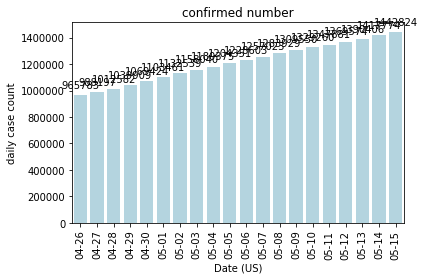

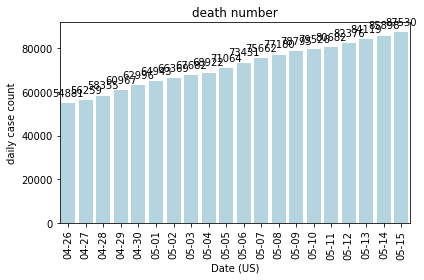

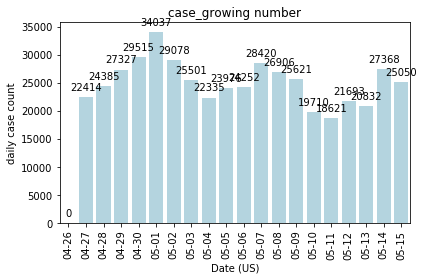

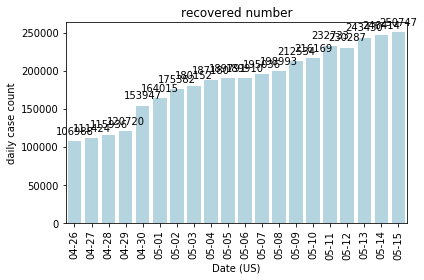

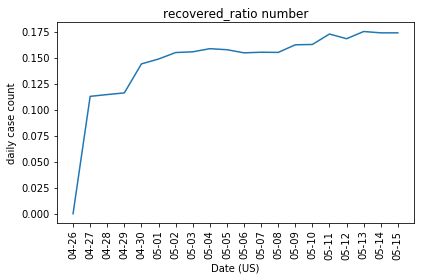

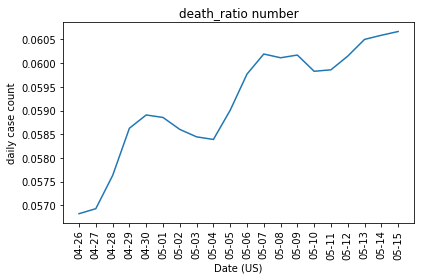

In [12]:
all_run(7)

<h2>US top-20 Most Confirmed Case States on COVID-19</h2>

<center><span style="color: red">RED</span></center>

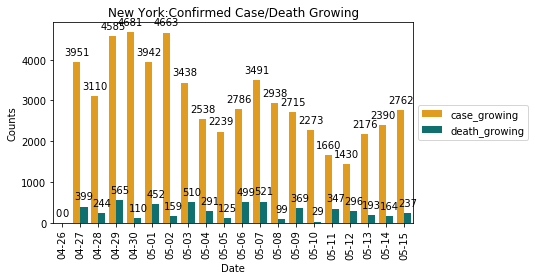

<center><span style="color: green">GREEN</span></center>

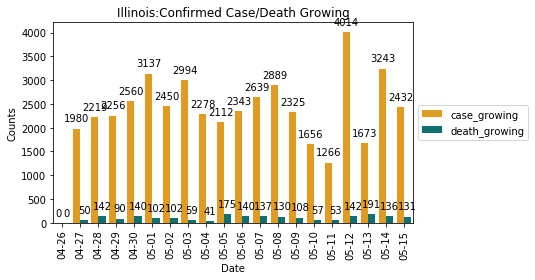

<center><span style="color: green">GREEN</span></center>

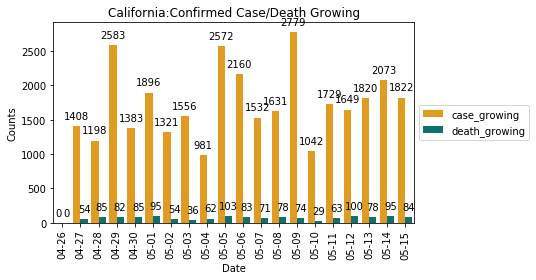

<center><span style="color: red">RED</span></center>

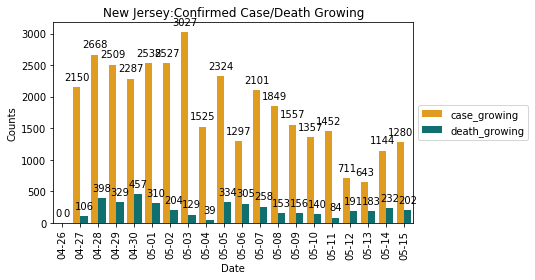

<center><span style="color: green">GREEN</span></center>

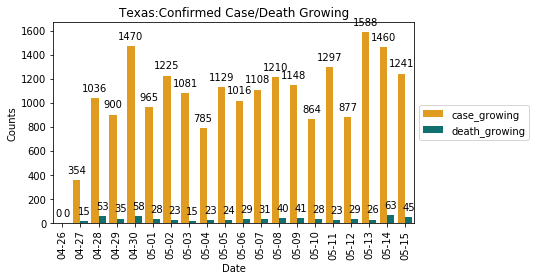

<center><span style="color: green">GREEN</span></center>

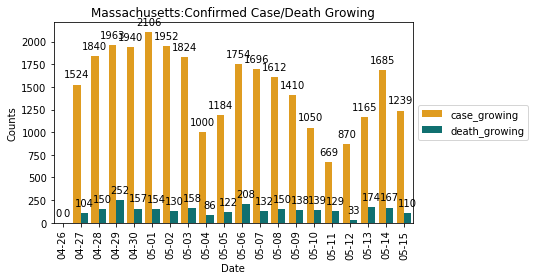

<center><span style="color: green">GREEN</span></center>

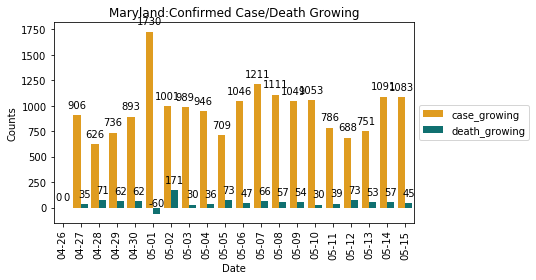

<center><span style="color: red">RED</span></center>

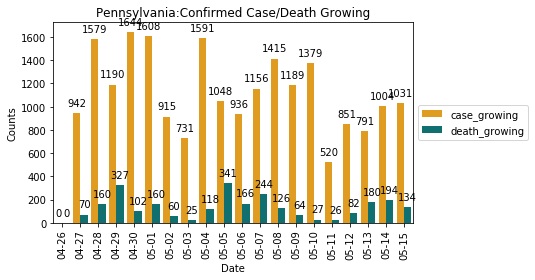

<center><span style="color: red">RED</span></center>

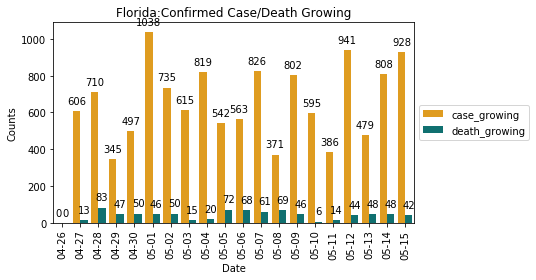

<center><span style="color: green">GREEN</span></center>

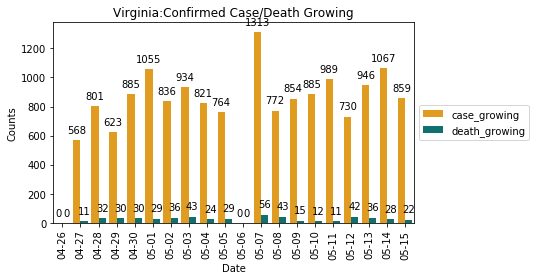

<center><span style="color: red">RED</span></center>

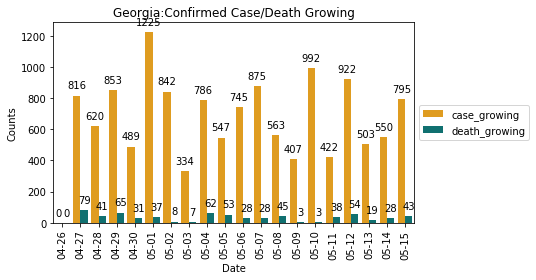

<center><span style="color: red">RED</span></center>

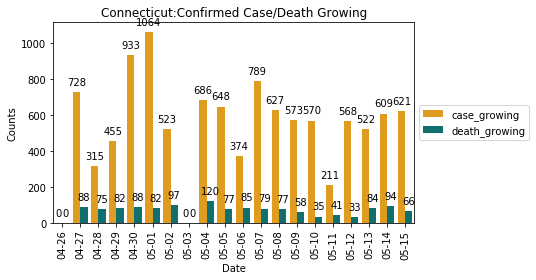

<center><span style="color: red">RED</span></center>

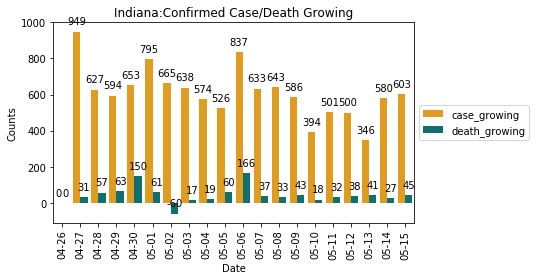

<center><span style="color: green">GREEN</span></center>

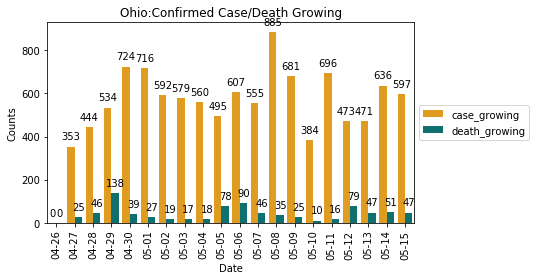

<center><span style="color: orange">ORANGE</span></center>

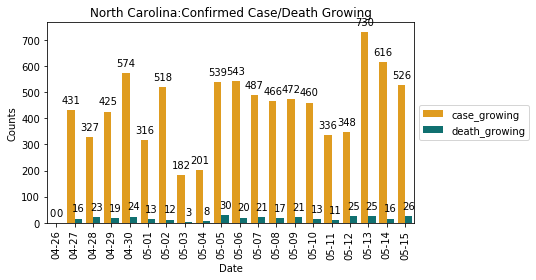

<center><span style="color: green">GREEN</span></center>

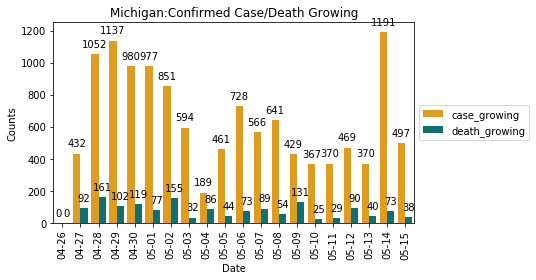

<center><span style="color: red">RED</span></center>

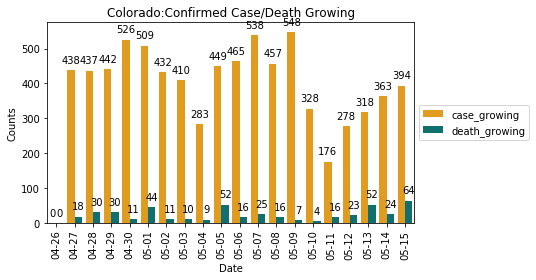

<center><span style="color: green">GREEN</span></center>

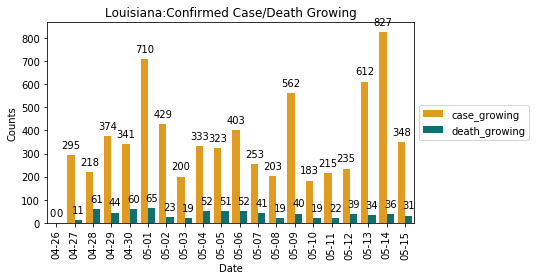

<center><span style="color: green">GREEN</span></center>

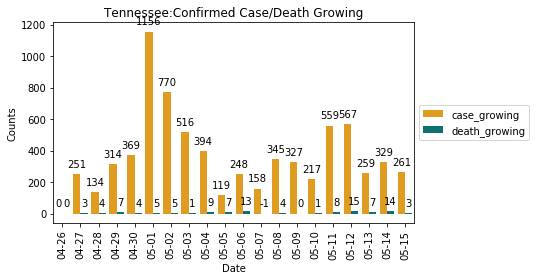

<center><span style="color: green">GREEN</span></center>

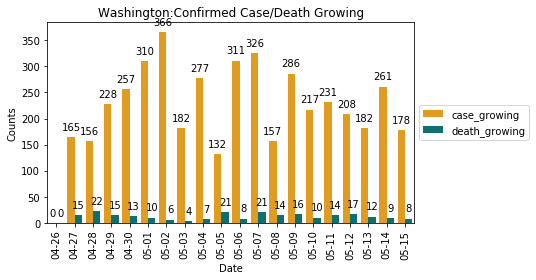

In [13]:
all_run(10)

<h2> Local Interests </h2>


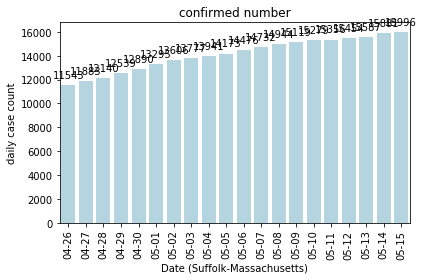

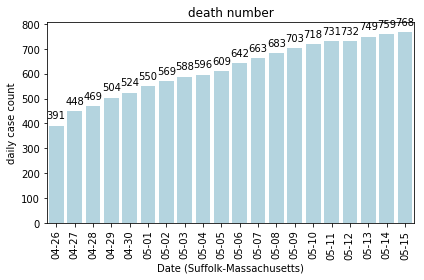

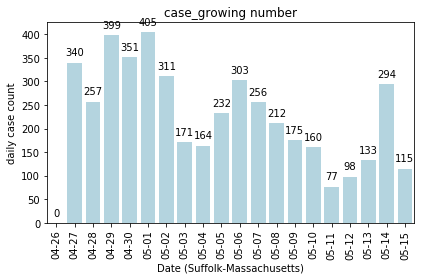

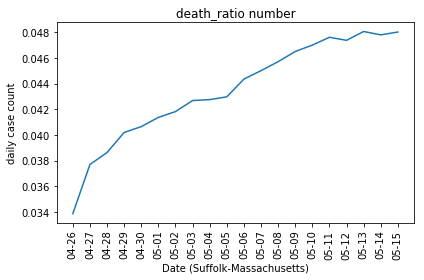

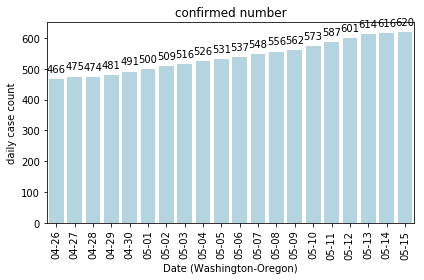

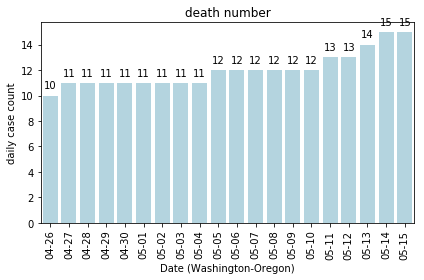

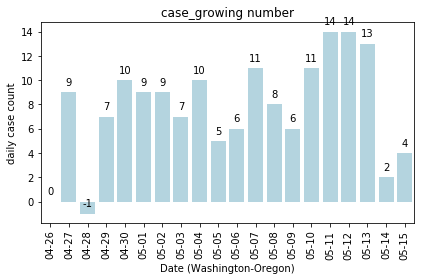

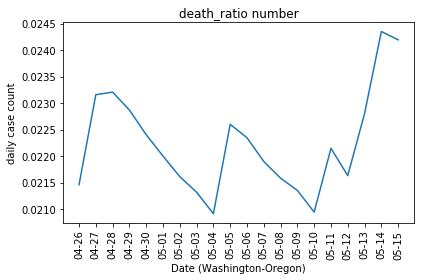

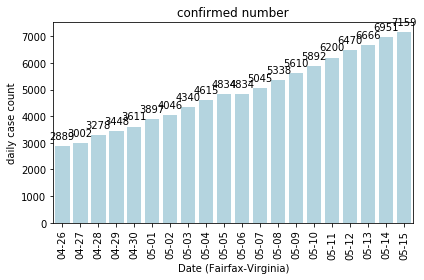

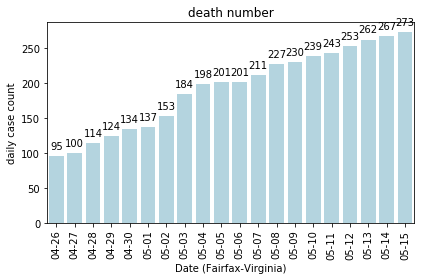

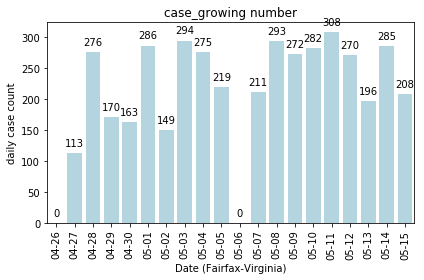

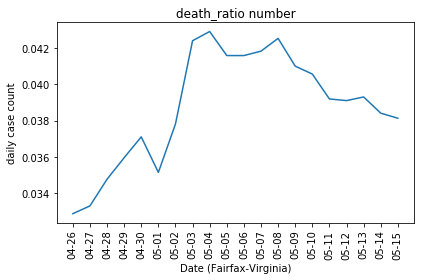

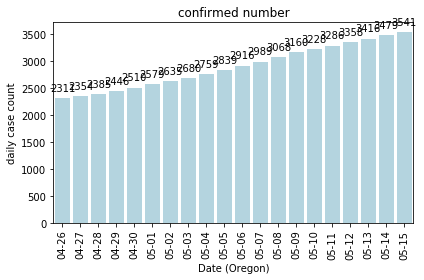

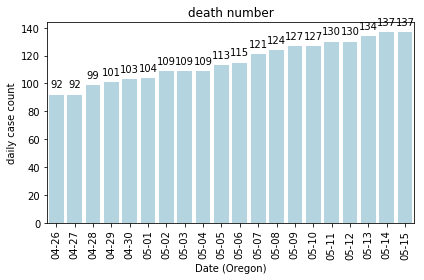

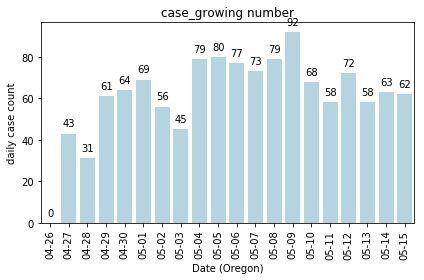

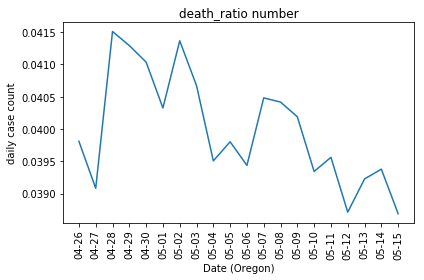

In [14]:
all_run(2)

Santa Clara, California


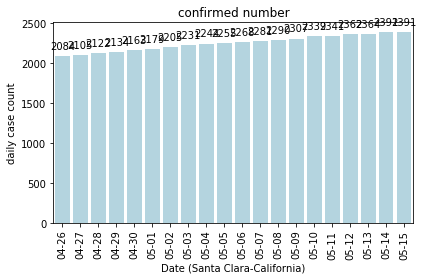

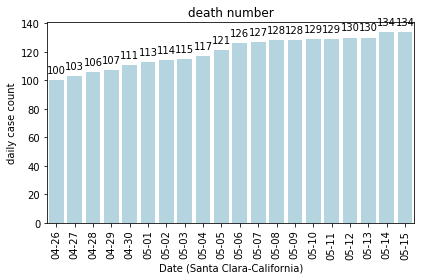

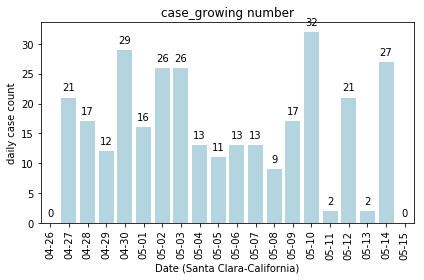

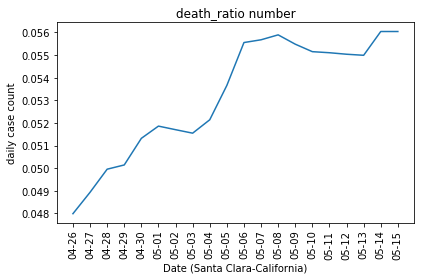

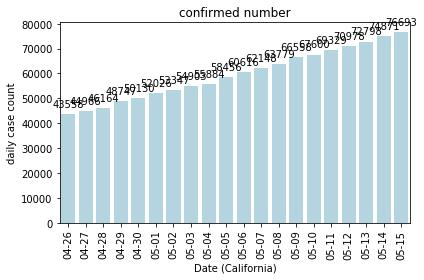

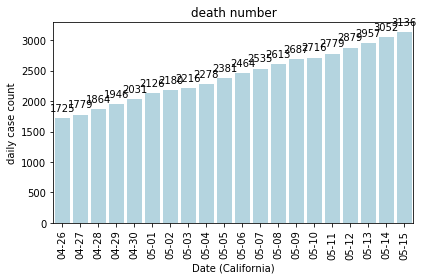

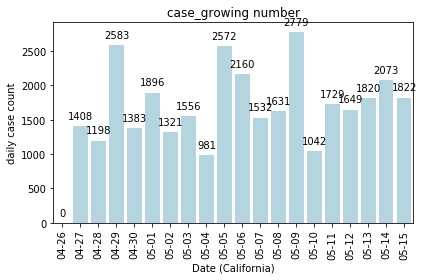

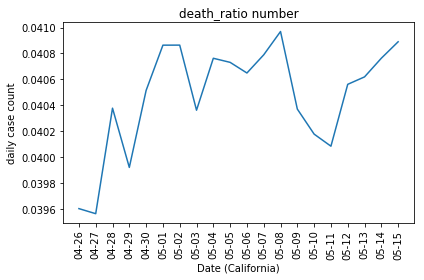

In [15]:
print("Santa Clara, California")
all_run(4)

In [16]:
#<h2> New York </h2>
#all_run(3)

In [17]:
## Testing code


    
def test1():
    df = getCasesByState("03-28-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    display(df.head(500))
    #printList(df)
    
def test2():
    df = getCasesByState("03-27-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    #display(df.head(500))
    #printList(df)
    
def test3():
    df = getCasesByState("03-22-2020", "Oregon")
    sum_confirmed = df["Confirmed"].sum()
    sum_death = df["Deaths"].sum()
    print(sum_confirmed,sum_death)
    #display(df.head(500))
    #printList(df)
    
def test4():
    daylist=["03-22-2020","03-23-2020","03-24-2020","03-25-2020","03-26-2020", "03-27-2020","03-28-2020"]
    df = findTrendSpeedByCounty(daylist, "Washington", "Oregon")
    chart(df, "confirmed")

def test5():
    #findState()
    #findCounty("California")
    day_list = genDayList(7, 1)
 
    df = findTrendSpeedByCounty(day_list, "Los Angeles", "California")
    #chart(df, "confirmed")
    display(df)
    
def test6():
    day_list = genDayList(7, 1)
 
    df1= findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chart(df1, "confirmed")
    chart(df1, "death")
        
    df = findTrendSpeedByState(day_list, "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByCounty(day_list, "Los Angeles", "California")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByCounty(day_list, "Santa Clara", "California")
    chart(df, "confirmed")
    chart(df, "death")
    
    df = findTrendSpeedByState(day_list, "New York")
    chart(df, "confirmed")
    chart(df, "death")
    
    
    
    
    

def test7():
    findCounty("Massachusetts")
    #findState()
    #findCountry()

def test8():
    day_list = genDayList(7, 1)
    df = findTrendSpeedByCountry(day_list, "US")
    chart(df, "confirmed")
    chart(df, "death")
    
def test9():
    day_list = genDayList(7, 1)
    df = findTrendSpeedByCountry(day_list, "US")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")
    df = findTrendSpeedByState(day_list, "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")   
    df = findTrendSpeedByCounty(day_list, "Washington", "Oregon")
    chart(df, "confirmed")
    chart(df, "death")
    linechart(df, "confirmed_growth")
    linechart(df, "death_growth")   

def test10():
    day_list = genDayList(7, 1)
 
    df1= findTrendByCounty(day_list, "Washington", "Oregon")
    display(df1)
    chart(df1, "confirmed")
    chart(df1, "death")

def testall():
    print("1====================================")
    test10()
    print("2====================================")
    test9()
    print("3====================================")
    test8()
    print("4====================================")
    test6()
    print("5====================================")
    
#test5()


In [18]:
%%sh
#ls -lrt ../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/
#more ../csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
#git pull
#more ../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv


In [19]:
#l = test7() 


<h3>Thanks to: </h3>
<ul>
<li><a href="https://github.com/CSSEGISandData/COVID-19">Johns Hopkins University Center</a> for their excellent work and data &
<li><a href="https://github.com/CSSEGISandData/COVID-19">Luigi Assom</a> for idea brainstorm 
</ul>

Contact: gxzhao80@hotmail.com if you like to cooperate or get my source code.
